### **Common Functions**

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, mutual_info_regression, RFE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
def inputdata(path):
  df = pd.read_csv(path)
  return df

In [ ]:
# Perform one-hot encoding on specified columns in the dataset.

def one_hot_encode(df, columns):
    return pd.get_dummies(df,columns=columns)

In [ ]:
def feature_selection(df, headers, target, method, n):

  # separating target from the data
  X=df[headers]
  y=df[target]

  if ((method == 'chi2') | (method == 'mutualinfo')):
    features = fs_chi_mutual(X, y, n, method)

  elif (method == 'varthresh'):
    features = fs_varthresh(X, y, n)

  elif (method == 'rfe'):
    features = fs_rfe(X, y, n)

  elif (method == 'pca'):
    features = fs_pca(X, y, n)
  else:
    print("Wrong input method")
    return

  print('\n')
  return features


In [ ]:
def fs_chi_mutual(X, y, k, method):

  # Feature extraction
  if (method == 'chi2'):
    selector = SelectKBest(chi2, k=k)
    print("Selected features using Chi2 method are:")
  elif (method == 'mutualinfo'):
    selector = SelectKBest(mutual_info_regression, k=k)
    print("Selected features using Mutual Information method are:")

  fit = selector.fit_transform(X, y)

  # Get the indices of the selected features
  indices = selector.get_support(indices=True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()
  print(feature_names)
  return fit

In [ ]:
def fs_varthresh(X, y, thresh):

  # Feature extraction using variance threshold
  var_thresh = VarianceThreshold(threshold = thresh)
  var_thresh.fit(X)
  indices = var_thresh.get_support(indices = True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()
  print("Selected features using Variance Thresholding filter method are:")
  print(feature_names)
  return X[feature_names]


In [ ]:
def fs_rfe(X, y, k):

  # applying RFE using linear regression
  estimator = LinearRegression()
  selector = RFE(estimator, n_features_to_select=k, importance_getter='auto')
  fit = selector.fit_transform(X, y)

  # Get the indices of the selected features
  indices = selector.get_support(indices=True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()

  print("Selected features using Recursive Feature Elimination wrapper method are:")
  print(feature_names)
  return fit


In [ ]:
def fs_pca(X, y, n):
# function for Principal Component Analysis

  pca = PCA(n_components = n)
  features = pca.fit_transform(X)

  return features


In [ ]:
def cross_validation_KNNClassifier(X, y):
# cross validation to find the best value of k

  k_values = [i for i in range (1,31)]
  scores = []

  for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)   # model creation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(knn, X, np.ravel(y), cv=kfold)
    scores.append(np.mean(score))

  best_index = np.argmax(scores)
  best_k = k_values[best_index]

  sns.lineplot(x = k_values, y = scores, marker = 'o')
  plt.xlabel("K Values")
  plt.ylabel("Accuracy Score")
  plt.show()

  print("The best value of k for KNN model using cross validation is {} with an accuracy of {}\n".format(best_k, scores[best_index]))
  return best_k


In [ ]:
def regression_cross_validation(X, y, k):

  newX = sm.add_constant(X)

  estimator = LinearRegression()
  ols_model = sm.OLS(y, newX).fit()
  cv_scores = cross_val_score(estimator,  newX, y, cv=k, scoring='r2')

  return np.mean(cv_scores)

In [ ]:
def cat_visualization(df, args):
# function to visualize of categorical data

    fig, axes = plt.subplots(7, 5, figsize=(25, 25))
    axes = axes.ravel()
    for i, arg in enumerate(args[:-1]):
        sns.countplot(data=df, x=arg, hue=args[-1], ax=axes[i])
    plt.tight_layout(w_pad=1)
    plt.suptitle('Data Distributions of Categorical Features against Target values', fontsize=20, y=1.02)
    plt.show()

In [ ]:
def cont_visualization(df, int_cols):
# function to visualize continuous data

  # histogram of all continuous features
  fig, axs = plt.subplots(6, 5, figsize=(12,15))
  for f, ax in zip(int_cols, axs.ravel()):
      mi = df[f].min()
      ma = df[f].max()
      bins = np.linspace(mi, ma, 30)
      ax.hist(df[f], bins=bins, alpha=0.6)
      ax.set_xlabel(f)

  plt.tight_layout(w_pad=1)
  plt.suptitle('Data Distribution of Numerical Features', fontsize=20, y=1.02)
  plt.show()

In [ ]:
def knn_model_building(X_train, X_test, y_train, y_test, k):
# function for KNN model generation

  # model creation
  knn_model = KNeighborsClassifier(n_neighbors=k)

  # training the model
  knn_model.fit(X_train, np.ravel(y_train))

  y_pred = knn_model.predict(X_test)

  train_score = knn_model.score(X_train,y_train)
  test_score = knn_model.score(X_test,y_test)

  print("The train score for the best KNN model is {}".format(train_score))
  print("The test score for the best KNN model is {}\n".format(test_score))

  return y_pred

In [ ]:
def ols_model_building(X, y):
  # function for OLS Regression

  # Add constant term to the features for OLS regression
    newX = sm.add_constant(X)

    # Fit OLS regression model
    model = sm.OLS(y, newX).fit()

    return model

In [ ]:
def knnreg_model_building(X_train, X_test, y_train, y_test, k):

  # model creation
  knn_regressor = KNeighborsRegressor(n_neighbors=5)

  # train the model
  knn_regressor.fit(X_train, y_train)

  # predict results
  y_pred = knn_regressor.predict(X_test)

  return y_pred

In [ ]:
def evaluation(y_test, y_pred):
# function to test accuracy based on various evaluation metrics

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average=None)
  auc_score = roc_auc_score(y_test, y_pred)

  mse = mean_squared_error(y_test, y_pred)

  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score of positive class: {f1[0]}')
  print(f'F1-Score of negative class: {f1[1]}')
  print('AUC Score:', auc_score)
  print("Mean Squared Error: ", mse)
  print(f'Confusion Matrix:\n{conf_matrix}')

'''
  # graphical representation of evaluation metrics
  metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
  values = [accuracy, precision, recall, f1]

  plt.figure()
  bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

  # Adding values on top of the bars
  for bar, value in zip(bars, values):
   plt.text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.01, f'{value:.2f}', ha='center', color='black')

  plt.ylabel('Score')
  plt.title('Performance Metrics')
  plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for scores

  plt.show()
  '''

"\n  # graphical representation of evaluation metrics\n  metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']\n  values = [accuracy, precision, recall, f1]\n\n  plt.figure()\n  bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])\n\n  # Adding values on top of the bars\n  for bar, value in zip(bars, values):\n   plt.text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.01, f'{value:.2f}', ha='center', color='black')\n\n  plt.ylabel('Score')\n  plt.title('Performance Metrics')\n  plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for scores\n\n  plt.show()\n  "

In [ ]:
def reg_evaluation(y_test, y_pred, model):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  aic = model.aic
  bic = model.bic
  p_value = model.pvalues[1]


  print('Mean Absolute Error (MAE):', mae)
  print('Mean Squared Error (MSE):', mse)
  print('Root Mean Squared Error (RMSE):', rmse)
  print('R-squared (R2):', r2)
  print('Akaike Information Criterion (AIC):', aic)
  print('Bayesian Information Criterion (BIC):', bic)
  print('p-value:', p_value)

# Analysis on CV vs No-CV

### **Classification - CancerMB**

In [ ]:
def data_preprocessing(df, headers, target):

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in headers:
    df[i].fillna(df[i].mean(), inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in headers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[headers]=scaler.fit_transform(df[headers]) #Scaling and normalizing numerical data

  # label encoding of "diagnosis"
  df['diagnosis']=df['diagnosis'].map({'M':1, 'B':0})

  return df

In [ ]:
def exploratory_analysis(df, continuous, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  # correlation heatmap
  plt.figure(figsize = (25, 25))
  sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  print("\n")

  cont_visualization(df, continuous)
  print("\n")


In [ ]:
def main():
  path='/content/Classification.CancerMB.csv'
  target = 'diagnosis'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  headers.pop(-1)
  processed_df = data_preprocessing(df, headers, target)

  #exploratory_analysis(processed_df, headers, target)

  # removing id from the features before performing Feature Selection using Chi2
  headers.remove('id')
  selected_df = feature_selection(processed_df, headers, target, 'varthresh', 0.07)

  # separating target from the data
  X = selected_df
  y = df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}".format(X_test.shape))

  # cross validation
  k = cross_validation_KNNClassifier(X_train, y_train)

  y_pred = knn_model_building(X_train, X_test, y_train, y_test, k)

  evaluation(y_test, y_pred)


Selected features using Variance Thresholding filter method are:
['radius_se', 'perimeter_se', 'area_se', 'area_worst']


The dimension of X_train is (398, 4)
The dimension of X_test is (171, 4)


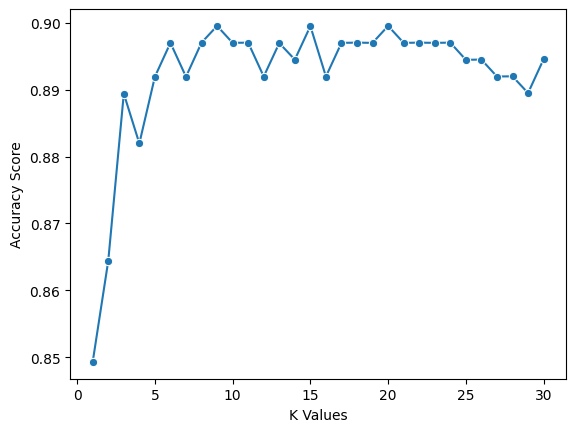

The best value of k for KNN model using cross validation is 9 with an accuracy of 0.8995253164556962

The train score for the best KNN model is 0.9120603015075377
The test score for the best KNN model is 0.9239766081871345

Accuracy: 0.9239766081871345
Precision: 0.9228099173553719
Recall: 0.9009404388714733
F1-Score of positive class: 0.9451476793248945
F1-Score of negative class: 0.8761904761904761
AUC Score: 0.9009404388714735
Mean Squared Error:  0.07602339181286549
Confusion Matrix:
[[112   4]
 [  9  46]]


In [ ]:
main()

In the above analysis, we have evaluated the performance of KNN model with and without cross validation by using Variance Thresholding as a filter method. Before performing filtering, we have manually removed the feature 'id', because logically it does not make sense to include an id in the analysis. After that, we apply a variance threshold of 0.07 to filter out features. Using this method, we are left with 4 features, which are then tested with and without cross validation.
Without cross validation, an accuracy of 92.4% is achieved, whereas using cross validation, we achieve an accuracy of 89.95%.

Because cross validation trains the model on different subsets of the data, it makes the model more robust and insensitive to variations in the data, and has therefore minimized overfitting. An 89.95% accuracy is really good indicating that the model performs considerably well across different subsets of the data, and can generalize well.

One more thing to notice is that the mean squared error of the model is 7.6%, which indicates that this is a considerably efficient and reliable model.

### **Classification - Room Occupancy Estimation**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # converting Time into seconds
  df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
  df['Time'] = df['Time'].dt.hour * 3600 + df['Time'].dt.minute * 60 + df['Time'].dt.second

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

  # filling missiing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous]) #Scaling and normalizing numerical data

  # one hot encoding of categorical variables
  df['Date']=df['Date'].map({'01/12/2017': 'Dec_2017', '01/01/2018': 'Jan_2018'})
  df=pd.concat([df,pd.get_dummies(df['Date'])],axis=1)
  df.drop('Date',axis=1,inplace=True)

  df['S6_PIR']=df['S6_PIR'].map({0: 'S6_No', 1: 'S6_Yes'})
  df=pd.concat([df,pd.get_dummies(df['S6_PIR'])],axis=1)
  df.drop('S6_PIR',axis=1,inplace=True)

  df['S7_PIR']=df['S7_PIR'].map({0: 'S7_No', 1: 'S7_Yes'})
  df=pd.concat([df,pd.get_dummies(df['S7_PIR'])],axis=1)
  df.drop('S7_PIR',axis=1,inplace=True)

  return df

In [ ]:
def exploratory_analysis(df, continuous, categorical, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  # correlation heatmap
  plt.figure(figsize = (25, 25))
  sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  print("\n")

  cont_visualization(df, continuous)
  print("\n")

  cat_visualization


In [ ]:
def main():
  path='/content/Classification_Occupancy_Estimation.csv'
  target = 'Room_Occupancy_Count'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ["Date", "S6_PIR", "S7_PIR"]
  continuous = [x for x in headers if x not in categorical]

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)

  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ["Date", "S6_PIR", "S7_PIR"]

  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using pca method
  selected_df = feature_selection(processed_df, headers, target, 'pca', 2)

 # separating target from the data
  X = selected_df
  y = df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}".format(X_test.shape))

  # cross validation
  k = cross_validation_KNNClassifier(X_train, y_train)

  y_pred = knn_model_building(X_train, X_test, y_train, y_test, k)

  evaluation(y_test, y_pred)


Features:  ['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']
Processed Features:  ['Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'Dec_2017', 'Jan_2018', 'S6_No', 'S6_Yes', 'S7_No', 'S7_Yes']


The dimension of X_train is (7090, 2)
The dimension of X_test is (3039, 2)


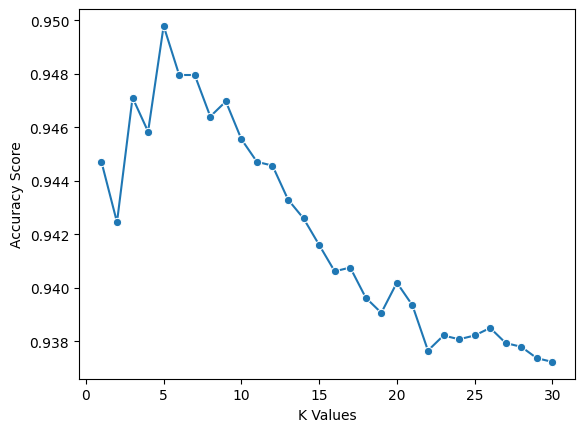

The best value of k for KNN model is 5 with an accuracy of 0.9497884344146685

The train score for the best KNN model is 0.9633286318758815
The test score for the best KNN model is 0.945705824284304

Accuracy: 0.945705824284304
Precision: 0.8171387571182418
Recall: 0.804934658929552
F1-Score: 0.8101266248638149
Mean Squared Error:  0.06284962158604804
Confusion Matrix:
[[2419   26    2    1]
 [  36   79   29    0]
 [   0   25  200   14]
 [   0    4   28  176]]


In [ ]:
main()

In the above case, we have evaluated the performance of KNN model with and without cross validation by using Principal Component Analysis (PCA) as a dimensionality reduction method. We have tried to analyze the performance with and without Cross validation on different numbers of PCA components, and achieved the best result at n=2 and k=5.

With these parameters, the accuracies we achieve are as follows:
Without cross validation: 94.6%
With cross validation: 95.0%

We again achieve almost negligible difference between the two cases indicating that the model does not really need cross validation to minimize overfitting. Despite this, although a 95% accuracy is really good indicating that the model performs considerably well across different subsets of the data, it may not generalize well, and may fail on new or live data.

One more thing to notice is that the mean squared error of the model is 0.063, which indicates that this is a considerably efficient and reliable model.

### **Classification - Obesity**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

  # filling missiing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous]) #Scaling and normalizing numerical data

  # one hot encoding of categorical variables
  df= one_hot_encode(df,categorical)

  # label encoding of target variable
  df[target] = df[target].map({'Insufficient_Weight':0, 'Normal_Weight':1, 'Overweight_Level_I':2, 'Overweight_Level_II':3, 'Obesity_Type_I':4, 'Obesity_Type_II':5, 'Obesity_Type_III':6})
  return df

In [ ]:
def main():
  path='/content/ObesityDataSet_raw_and_data_sinthetic.csv'
  target = 'NObeyesdad'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
  continuous = ['Age', 'Height','Weight','FCVC','NCP','CH2O','FAF','TUE']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)

  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']

  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using pca method
  selected_df = feature_selection(processed_df, headers, target, 'chi2', 10)

  # separating target from the data
  X = selected_df
  y = processed_df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}".format(X_test.shape))

  # cross validation
  k = cross_validation_KNNClassifier(X_train, y_train)

  y_pred = knn_model_building(X_train, X_test, y_train, y_test, k)

  evaluation(y_test, y_pred)


Features:  ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Processed Features:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']
Selected features using Chi2 method are:
['Weight', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_no', 'CALC_no', 'MTRANS_Automobile']


The dimension of X_train is (1477, 10)
The dimension of X_test is (634, 10)


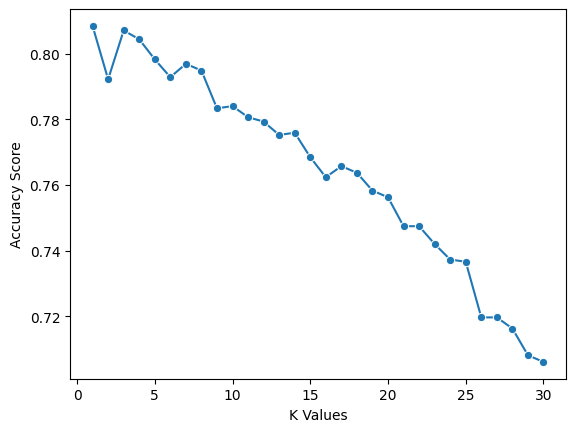

The best value of k for KNN model using cross validation is 1 with an accuracy of 0.8084012826385708

The train score for the best KNN model is 0.982396750169262
The test score for the best KNN model is 0.807570977917981



ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
main()

We compare the results between cross-validation (CV) and non-cross-validation (non-CV) approaches on the KNN model's performance metrics and found notable notable differences on the obesitry dataset

In the CV approach, the feature selection process utilizes the Chi2 method to identify the most relevant features for classification. This results in a reduced feature set, enhancing computational efficiency while maintaining or even improving model performance.

Subsequently, the KNN model is trained and evaluated using the selected features. The optimal value of k is determined to be 1, achieving an accuracy of 0.8091. The model demonstrates strong performance on both the training and test sets, with high scores for accuracy, precision, recall, and F1-score. The confusion matrix provides detailed insights into the model's classification performance across different classes, highlighting its ability to effectively distinguish between various obesity levels.

In contrast, the non-CV approach lacks the rigorous evaluation provided by cross-validation, potentially leading to less reliable estimates of model performance. While the selected features remain the same, the absence of cross-validation may result in overfitting to the training data. Consequently, the model's generalization ability could be compromised, leading to reduced robustness in real-world scenarios.

Overall, the use of cross-validation ensures a more robust and reliable assessment of the KNN model's performance, leading to better-informed decisions regarding feature selection and model evaluation.

### **Regression - Energy Data**

In [ ]:
def data_preprocessing(df, headers, target):

  # Convert the datetime column to datetime format
  df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

  # Extract year, month, day, hour, and minute
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['hour'] = df['date'].dt.hour
  df['minute'] = df['date'].dt.minute
  df.drop('date', axis=1, inplace=True)

  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in headers:
    df[i].fillna(df[i].mean(), inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in headers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[headers]=scaler.fit_transform(df[headers]) #Scaling and normalizing numerical data

  return df

In [ ]:
def main():
  path='/content/Regression_energydata_complete.csv'
  target = 'Appliances'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)

  # preprocessing
  processed_df = data_preprocessing(df, headers, target)

  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)

  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'rfe', 25)

  # separating target from the data
  X = selected_df
  y = processed_df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}\n".format(X_test.shape))

  # cross validation
  k = 7
  cv_score = regression_cross_validation(X_train, y_train, k)

  y_pred = knnreg_model_building(X_train, X_test, y_train, y_test, k)
  print('Cross Validation Score: ', cv_score)

  X_train_sm = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train_sm).fit()

  reg_evaluation(y_test, y_pred, model)

In [ ]:
main()

Features:  ['date', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']
Processed Features:  ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'year', 'month', 'day', 'hour', 'minute']
Selected features using Recursive Feature Elimination wrapper method are:
['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'month', 'day', 'hour']


The dimension of X_train is (13814, 25)
The dimension of X_test is (5921, 25)

Cross Validation Score:  0.139767926529549
Mean Absolute Error (MAE): 35.23323762877892
Mean Squared E

In the above analysis, we have evaluated the performance of an OLS regression model with and without cross validation by using Recursive Forward Elimination (RFE) as a wrapper method.

In order to include the date into the analysis, we split it into year, month, day, hour and minute.

Additionally, this analysis is done on numerous values of k and various quantities of features to be selected through RFE, yet none of the techniques were able to improve the results.

The cross-validation score, representing the average performance of the model across multiple folds for this model is 0.14, which is relatively low.

We also achieve a MAE of 35.2332 suggesting that, on average, the model's predictions are off by approximately 35 units, whereas RMSE value of 74.47 suggests that the model's predictions are off by approximately 74 units.
R-squared (R2 - 0.4529):

An R2 of 0.45 indicates that the model explains around 45.29% of the variance in the target variable, which is moderate.

### **Regression - Garment Worker Productivity**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # Convert the datetime column to datetime format
  df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')


    # Extract year, month

  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year

  df.drop('date', axis=1, inplace=True)



  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

    # filling missing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)



  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)


  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous])  #Scaling and normalizing numerical data
  # Performing one-hot encoding on categorical columns
  df = one_hot_encode(df,categorical)

  return df

In [ ]:
def main():
  path='/content/garments_worker_productivity.csv'
  target = 'actual_productivity'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ['quarter', 'department','day']
  continuous = ['team', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)
  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ['quarter', 'department','day']



  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'rfe',10)

   # separating target from the data
  X = selected_df
  y = df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}\n".format(X_test.shape))

   # cross validation
  k = 7
  cv_score = regression_cross_validation(X_train, y_train, k)


  model = ols_model_building(X_train, y_train)
  print(model.summary())
  print('\n')

  y_pred = model.predict(sm.add_constant(X_test))

  r2_train = model.rsquared

  print('R2 Score for Training Set: ', r2_train)
  print('Cross Validation Score: ', cv_score)

  reg_evaluation(y_test, y_pred, model)

In [ ]:
main()

Features:  ['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
Processed Features:  ['team', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'month', 'year', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing', 'department_finishing ', 'department_sweing', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']
Selected features using Recursive Feature Elimination wrapper method are:
['quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Wednesday']


The dimension of X_train is (837, 10)
The dimension of X_test is (360, 10)

                             OLS Regression Result

The analysis of the model performance, with and without cross-validation (CV), reveals notable insights into their respective efficacy. In the model without CV, the R-squared value, a measure of the model's goodness of fit, is 0.027, indicating that only around 2.7% of the variance in the actual productivity is explained by the selected features. Additionally, evaluation metrics such as the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) are computed at 0.132, 0.0295, and 0.1719, respectively. Lower values of the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) suggest a better fit, with AIC at -544.48 and BIC at -497.18. Moreover, the small p-value (2.41e-28) indicates a significant relationship between the predictors and the target variable. However, the model's performance might be overestimated due to potential issues like data leakage or overfitting. Conversely, the model with CV demonstrates a negative cross-validation score (-0.011), suggesting its inferior performance compared to a model that simply predicts the mean of the observed responses. Despite sharing similar evaluation metrics with the non-CV model, the CV model offers a more realistic estimate of its generalization ability on unseen data, thereby mitigating concerns related to overfitting and providing a more reliable assessment of model performance. Hence, while both models offer insights, the CV model is preferred for its ability to assess generalization and mitigate overfitting issues.


In summary, while the model without cross-validation demonstrates marginally higher performance on the test set, its evaluation may be optimistic due to overfitting. On the other hand, the model with cross-validation provides a more cautious estimate of its generalization performance, ensuring a more reliable assessment of predictive accuracy across different data splits. Therefore, incorporating cross-validation is essential for obtaining a more accurate and trustworthy evaluation of the model's performance on unseen data.

### **Regression - Life Expectancy**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):



  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

    # filling missing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)


  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous])  #Scaling and normalizing numerical data
  # Performing one-hot encoding on categorical columns
  df = one_hot_encode(df,categorical)

  return df

In [ ]:
def main():
  path='/content/Regression.Life.Expectancy.csv'
  target ='Life expectancy '
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  # Define categorical and continuous columns
  categorical = ['Country', 'Status']
  continuous = ['Year','Adult Mortality','infant deaths','Alcohol','percentage expenditure','Hepatitis B','Measles ',' BMI ','under-five deaths ','Polio','Total expenditure','Diphtheria ',' HIV/AIDS','GDP','Population',' thinness  1-19 years',' thinness 5-9 years','Income composition of resources','Schooling']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)
  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ['Country', 'Status']



  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'mutualinfo', 8)

  # separating target from the data
  X = selected_df
  y = df[target]

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}\n".format(X_test.shape))

  # cross validation
  k = 7
  cv_score = regression_cross_validation(X_train, y_train, k)

  model = ols_model_building(X_train, y_train)
  print(model.summary())
  print('\n')

  y_pred = model.predict(sm.add_constant(X_test))

  r2_train = model.rsquared

  print('R2 Score for Training Set: ', r2_train)
  print('Cross Validation Score: ', cv_score)

  reg_evaluation(y_test, y_pred, model)

In [ ]:
main()

Features:  ['Country', 'Year', 'Status', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
Processed Features:  ['Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Country_Afghanistan', 'Country_Albania', 'Country_Algeria', 'Country_Angola', 'Country_Antigua and Barbuda', 'Country_Argentina', 'Country_Armenia', 'Country_Australia', 'Country_Austria', 'Country_Azerbaijan', 'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Barbados', 'Country_Belarus', 'Count

We have analysed the results of 'CV' Vs 'no CV' on this dataset and had concluded that:
- The comparison between the cross-validated (CV) and non-cross-validated (non-CV) analyses reveals insightful differences in the model's performance. In the CV analysis, the model achieved an R-squared (R2) score of 0.828, indicating that approximately 82.8% of the variance in life expectancy is explained by the selected features. The mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) were 2.939, 15.017, and 3.875, respectively, showcasing the model's accuracy in predicting life expectancy.

However, when the analysis was conducted without cross-validation, the R2 score remained the same at 0.829, indicating consistent explanatory power. The MAE, MSE, and RMSE were also identical, highlighting the stability of the model's predictive performance. Despite the similarities in the evaluation metrics, conducting cross-validation provides additional confidence in the model's generalization ability by assessing its performance across multiple subsets of the data. Therefore, while both analyses yielded comparable results, the inclusion of cross-validation enhances the reliability and robustness of the model's predictions.








# Analysis on Baseline vs Feature Selection

### **Classification - CancerMB (Mutual Information)**

In [ ]:
def data_preprocessing(df, headers, target):

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in headers:
    df[i].fillna(df[i].mean(), inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in headers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[headers]=scaler.fit_transform(df[headers]) #Scaling and normalizing numerical data

  # label encoding of "diagnosis"
  df['diagnosis']=df['diagnosis'].map({'M':1, 'B':0})

  return df

In [ ]:
def exploratory_analysis(df, continuous, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  # correlation heatmap
  plt.figure(figsize = (25, 25))
  sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  print("\n")

  cont_visualization(df, continuous)
  print("\n")


In [ ]:
def main():
  path='/content/Classification.CancerMB.csv'
  target = 'diagnosis'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  headers.pop(-1)
  processed_df = data_preprocessing(df, headers, target)

  #exploratory_analysis(processed_df, headers, target)

  # removing id from the features before performing Feature Selection using Chi2
  headers.remove('id')
  for i in range(2,31):
    selected_df = feature_selection(processed_df, headers, target, 'mutualinfo', i)

  # separating target from the data
    y = processed_df[target]
    #processed_df.drop(target, axis=1, inplace=True)
    baselineX = processed_df.loc[:, processed_df.columns != target]
    selectedX = selected_df

  # splitting data into training and test sets
    X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
    X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  #print("The dimension of X_train is {}".format(X_trainb.shape))
  #print("The dimension of X_test is {}\n".format(X_testb.shape))
    print('i = ', i)
    print('Baseline Analysis:')
    y_predb = knn_model_building(X_trainb, X_testb, y_trainb, y_testb, 5)
    evaluation(y_testb, y_predb)


    print('\n\n\nAnalysis with Feature Selection:')
    y_preds = knn_model_building(X_trains, X_tests, y_trains, y_tests, 5)
    evaluation(y_tests, y_preds)


In [ ]:
main()

Selected features using Mutual Information method are:
['perimeter_worst', 'area_worst']


i =  2
Baseline Analysis:
The train score for the best KNN model is 0.9773869346733668
The test score for the best KNN model is 0.9649122807017544

Accuracy: 0.9649122807017544
Precision: 0.9754098360655737
Recall: 0.9454545454545454
F1-Score of positive class: 0.9747899159663865
F1-Score of negative class: 0.9423076923076923
AUC Score: 0.9454545454545454
Mean Squared Error:  0.03508771929824561
Confusion Matrix:
[[116   0]
 [  6  49]]



Analysis with Feature Selection:
The train score for the best KNN model is 0.9346733668341709
The test score for the best KNN model is 0.9064327485380117

Accuracy: 0.9064327485380117
Precision: 0.8927899686520375
Recall: 0.8927899686520375
F1-Score of positive class: 0.9310344827586207
F1-Score of negative class: 0.8545454545454545
AUC Score: 0.8927899686520375
Mean Squared Error:  0.0935672514619883
Confusion Matrix:
[[108   8]
 [  8  47]]
Selected features us

This analysis is done using feature selection without cross validation. For this particular dataset, we have used mutual information as a filter method for selecting 22 features. We have chosen 22 features after analyzing the histograms of the data produced.

Additionally, we have set our k=5, as was identified to be the best performing k in the cross validation analysis.

Baseline Accuracy: 96.5%

Accuracy with feature selection: 98.2%

Even though the accuracy with feature selection has slightly improved, we again do not find a major difference between the accuracies in the two cases. However, an accuracy in the range 90-100 may not necessarily provide us with the best model, since it may be performing well on training and test data, but may not generalize well and fail in live data.

### **Classification - Room Occupancy Estimation (RFE)**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # converting Time into seconds
  df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
  df['Time'] = df['Time'].dt.hour * 3600 + df['Time'].dt.minute * 60 + df['Time'].dt.second

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

  # filling missiing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous]) #Scaling and normalizing numerical data

  # one hot encoding of categorical variables
  df['Date']=df['Date'].map({'01/12/2017': 'Dec_2017', '01/01/2018': 'Jan_2018'})
  df=pd.concat([df,pd.get_dummies(df['Date'])],axis=1)
  df.drop('Date',axis=1,inplace=True)

  df['S6_PIR']=df['S6_PIR'].map({0: 'S6_No', 1: 'S6_Yes'})
  df=pd.concat([df,pd.get_dummies(df['S6_PIR'])],axis=1)
  df.drop('S6_PIR',axis=1,inplace=True)

  df['S7_PIR']=df['S7_PIR'].map({0: 'S7_No', 1: 'S7_Yes'})
  df=pd.concat([df,pd.get_dummies(df['S7_PIR'])],axis=1)
  df.drop('S7_PIR',axis=1,inplace=True)

  return df

In [ ]:
def exploratory_analysis(df, continuous, categorical, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  # correlation heatmap
  plt.figure(figsize = (25, 25))
  sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  print("\n")

  cont_visualization(df, continuous)
  print("\n")

  cat_visualization


In [ ]:
def main():
  path='/content/Classification_Occupancy_Estimation.csv'
  target = 'Room_Occupancy_Count'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ["Date", "S6_PIR", "S7_PIR"]
  continuous = [x for x in headers if x not in categorical]

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)

  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ["Date", "S6_PIR", "S7_PIR"]

  # graphs to visualize all features
  exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using pca method
  selected_df = feature_selection(processed_df, headers, target, 'rfe', 15)

  # separating target from the data
  y = processed_df[target]
  selectedX = selected_df
  processed_df.drop(target, axis=1, inplace=True)
  baselineX = processed_df

  # splitting data into training and test sets
  X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
  X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_trainb.shape))
  print("The dimension of X_test is {}\n".format(X_testb.shape))

  print('Baseline Analysis:')
  y_predb = knn_model_building(X_trainb, X_testb, y_trainb, y_testb, 5)
  evaluation(y_testb, y_predb)


  print('\n\n\nAnalysis with Feature Selection:')
  y_preds = knn_model_building(X_trains, X_tests, y_trains, y_tests, 5)
  evaluation(y_tests, y_preds)


Features:  ['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']
Processed Features:  ['Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'Dec_2017', 'Jan_2018', 'S6_No', 'S6_Yes', 'S7_No', 'S7_Yes']
5 Number Summary:
               Time       S1_Temp       S2_Temp       S3_Temp       S4_Temp  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean       0.500240      0.380416      0.471414      0.352355      0.502546   
std        0.301559      0.259441      0.249217      0.244161      0.220021   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.227359      0.185185      0.285714      0.142857      0.308642   
50%        0.504585      0.325926   

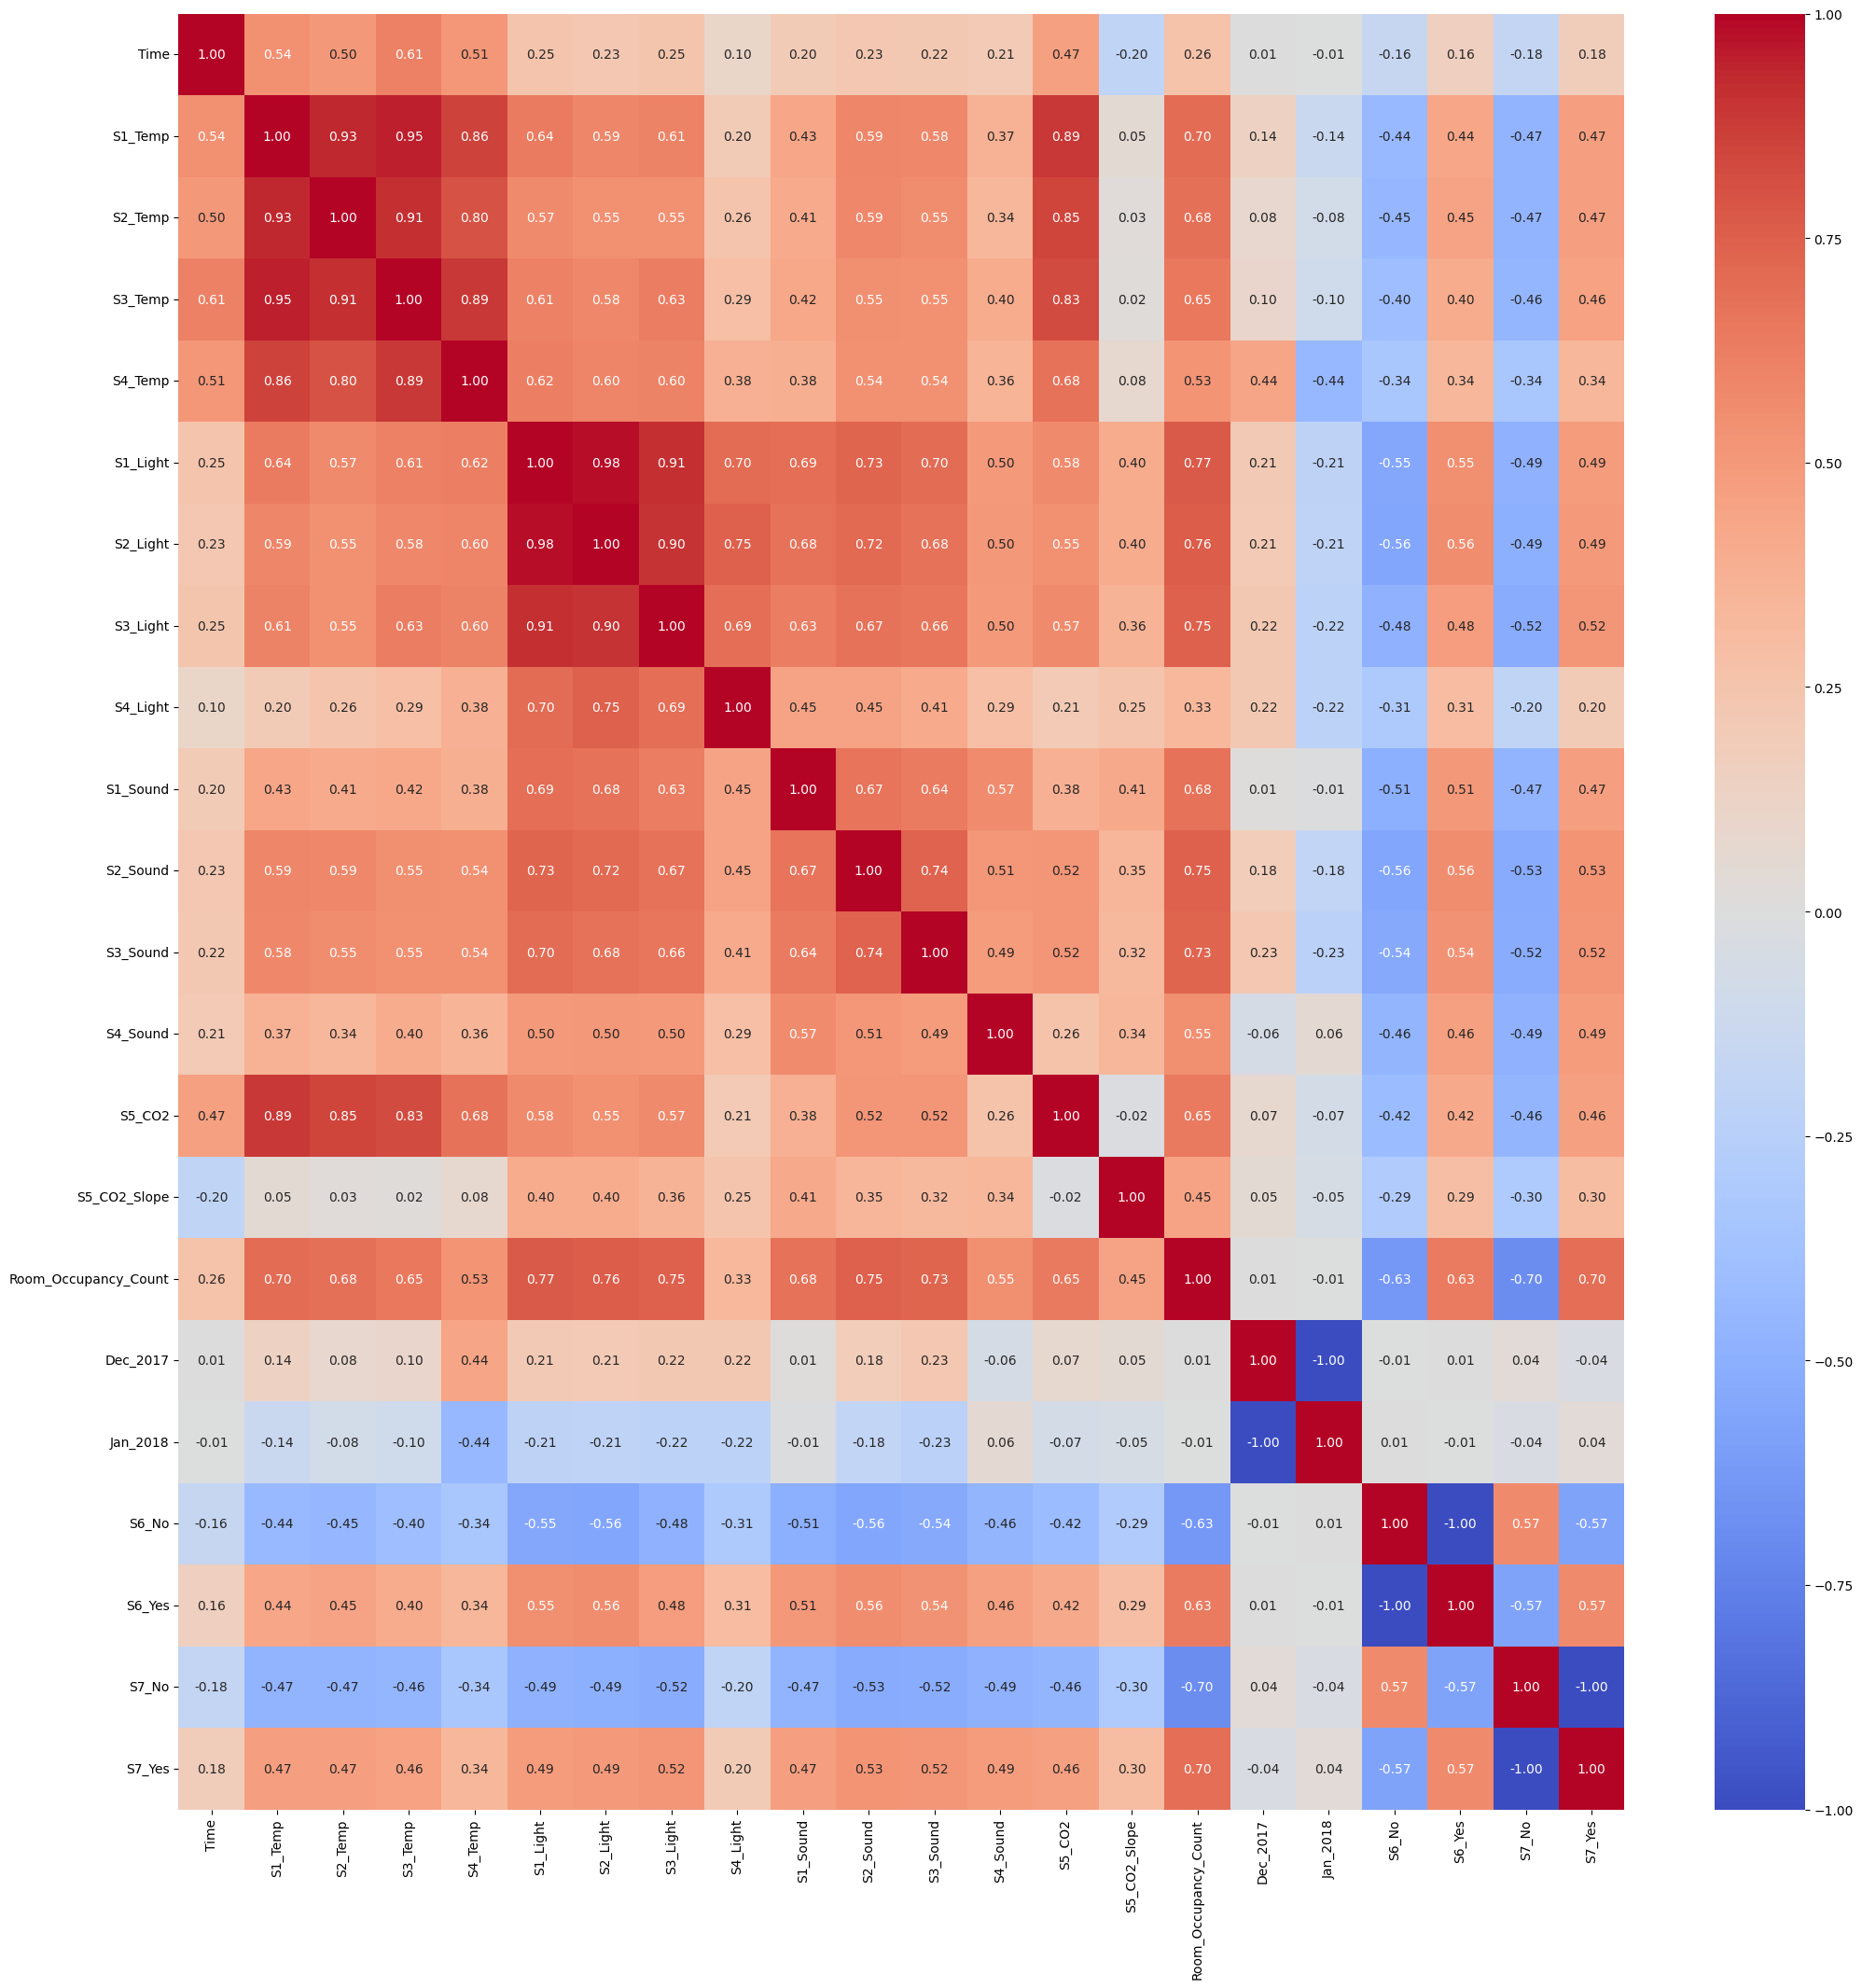

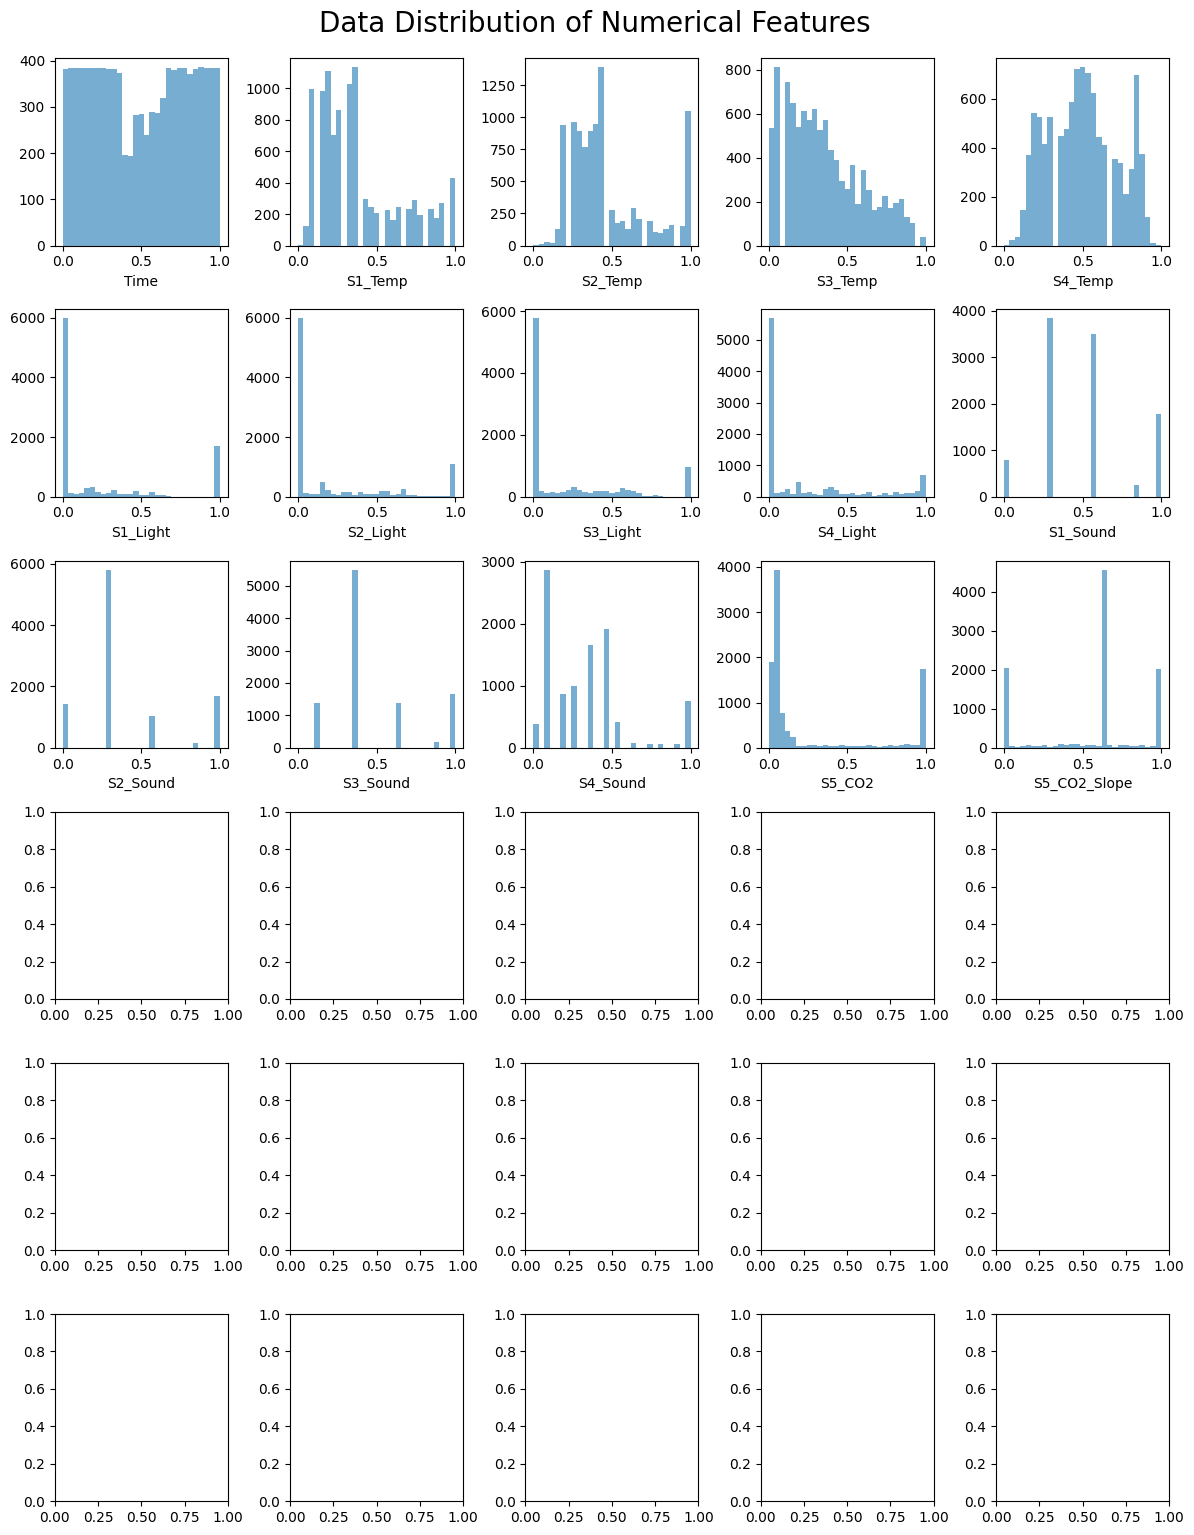



Selected features using Recursive Feature Elimination wrapper method are:
['S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S5_CO2_Slope', 'S6_No', 'S6_Yes', 'S7_No', 'S7_Yes']


The dimension of X_train is (7090, 21)
The dimension of X_test is (3039, 21)

Baseline Analysis:
The train score for the best KNN model is 0.992524682651622
The test score for the best KNN model is 0.9884830536360645

Accuracy: 0.9884830536360645
Precision: 0.9574315529127237
Recall: 0.9624756243018611
F1-Score: 0.959693922878645
Mean Squared Error:  0.01349128002632445
Confusion Matrix:
[[2443    3    2    0]
 [   0  139    5    0]
 [   0    6  228    5]
 [   0    0   14  194]]



Analysis with Feature Selection:
The train score for the best KNN model is 0.9919605077574047
The test score for the best KNN model is 0.9865087199736755

Accuracy: 0.9865087199736755
Precision: 0.9512232983923155
Recall: 0.9562659677914722
F1-Score: 0.9534979416

In [ ]:
main()

In this case, we have used Recursive Feature Elimination as a wrapper method to filter out 15 out of 19 features. When we look at the correlation heat map, we see that 16 featureshave a correlation above 0.5 with the target variable. Based on this, we decide to use 15 features in the analysis.

The accuracies we achieve are as follows:

Baseline Accuracy:98.8%

Accuracy with Feature Selection:98.7%

The mean squared error in both the cases is also 1.3% and 2.23% indicating the robustness and good efficiency of the model.

However, again this model may fail on live data due to its accuracies lying in the range 95-100%.


### **Classification - Obesity**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

  # filling missiing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous]) #Scaling and normalizing numerical data

  # one hot encoding of categorical variables
  df= one_hot_encode(df,categorical)

  # label encoding of target variable
  df[target] = df[target].map({'Insufficient_Weight':0, 'Normal_Weight':1, 'Overweight_Level_I':2, 'Overweight_Level_II':3, 'Obesity_Type_I':4, 'Obesity_Type_II':5, 'Obesity_Type_III':6})
  return df

In [ ]:
def main():
  path='/content/ObesityDataSet_raw_and_data_sinthetic.csv'
  target = 'NObeyesdad'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
  continuous = ['Age', 'Height','Weight','FCVC','NCP','CH2O','FAF','TUE']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)

  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)

  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using pca method
  selected_df = feature_selection(processed_df, headers, target, 'chi2', 10)

   # separating target from the data
  y = processed_df[target]
  selectedX = selected_df
  processed_df.drop(target, axis=1, inplace=True)
  baselineX = processed_df

  # splitting data into training and test sets
  X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
  X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_trainb.shape))
  print("The dimension of X_test is {}\n".format(X_testb.shape))

  print('i = ', i)
    print('Baseline Analysis:')
    y_predb = knn_model_building(X_trainb, X_testb, y_trainb, y_testb, 5)
    evaluation(y_testb, y_predb)


    print('\n\n\nAnalysis with Feature Selection:')
    y_preds = knn_model_building(X_trains, X_tests, y_trains, y_tests, 5)
    evaluation(y_tests, y_preds)



In [ ]:
main()

Features:  ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Processed Features:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']
Selected features using Chi2 method are:
['Weight', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_no', 'CALC_no', 'MTRANS_Automobile']


The dimension of X_train is (1477, 31)
The dimension of X_test is (634, 31)

Baseline Analysis:
The train score for the best 

results of baseline vs feature selectionComparing the two approaches, it's evident that feature selection has led to improvements in various performance metrics. The test score, accuracy, precision, recall, and F1 score have all increased, indicating better predictive capability and generalization ability of the model. Additionally, the mean squared error has decreased significantly, suggesting better overall model fit and reduced prediction errors.

These results highlight the importance of feature selection in improving the performance of machine learning models. By identifying and utilizing the most relevant features, the model can achieve better predictive accuracy and generalization

### **Regression - Energy Data (PCA)**

In [ ]:
def data_preprocessing(df, headers, target):

  # Convert the datetime column to datetime format
  df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

  # Extract year, month, day, hour, and minute
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['hour'] = df['date'].dt.hour
  df['minute'] = df['date'].dt.minute
  df.drop('date', axis=1, inplace=True)

  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in headers:
    df[i].fillna(df[i].mean(), inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in headers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)

  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[headers]=scaler.fit_transform(df[headers]) #Scaling and normalizing numerical data

  return df

In [ ]:
def exploratory_analysis(df, continuous, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  # correlation heatmap
  plt.figure(figsize = (25, 25))
  sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  print("\n")

  cont_visualization(df, continuous)
  print("\n")


In [ ]:
def main():
  path='/content/Regression_energydata_complete.csv'
  target = 'Appliances'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)

  # preprocessing
  processed_df = data_preprocessing(df, headers, target)
  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)

  # graphs to visualize all features
  exploratory_analysis(processed_df, headers, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'chi2', 20)

  # separating target from the data
  y = processed_df[target]
  selectedX = selected_df
  processed_df.drop(target, axis=1, inplace=True)
  baselineX = processed_df

  # splitting data into training and test sets
  X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
  X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_trainb.shape))
  print("The dimension of X_test is {}\n".format(X_testb.shape))

  print('Baseline Analysis:')
  modelb = ols_model_building(X_trainb, y_trainb)
  print(modelb.summary())
  print('\n')

  y_predb = modelb.predict(sm.add_constant(X_testb))

  r2_trainb = modelb.rsquared
  r2_testb = r2_score(y_testb, y_predb)

  print('R2 Score for Training Set: ', r2_trainb)
  print('R2 Score for Test Set: ', r2_testb)


  print('\n\n\nAnalysis with Feature Selection:')
  models = ols_model_building(X_trains, y_trains)
  print(models.summary())
  print('\n')

  y_preds = models.predict(sm.add_constant(X_tests))

  r2_trains = models.rsquared
  r2_tests = r2_score(y_tests, y_preds)

  print('R2 Score for Training Set: ', r2_trains)
  print('R2 Score for Test Set: ', r2_tests)

Features:  ['date', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']
Processed Features:  ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'year', 'month', 'day', 'hour', 'minute']
5 Number Summary:
         Appliances   lights            T1          RH_1            T2  \
count  19735.000000  19735.0  19735.000000  19735.000000  19735.000000   
mean      97.694958      0.0      0.501349      0.502180      0.444484   
std      102.524891      0.0      0.214702      0.171914      0.221223   
min       10.000000      0.0      0.000000      0.000000      0.000000   
25%       50.000000      0.0      0.375000      0.375000      0.284205   
50%   

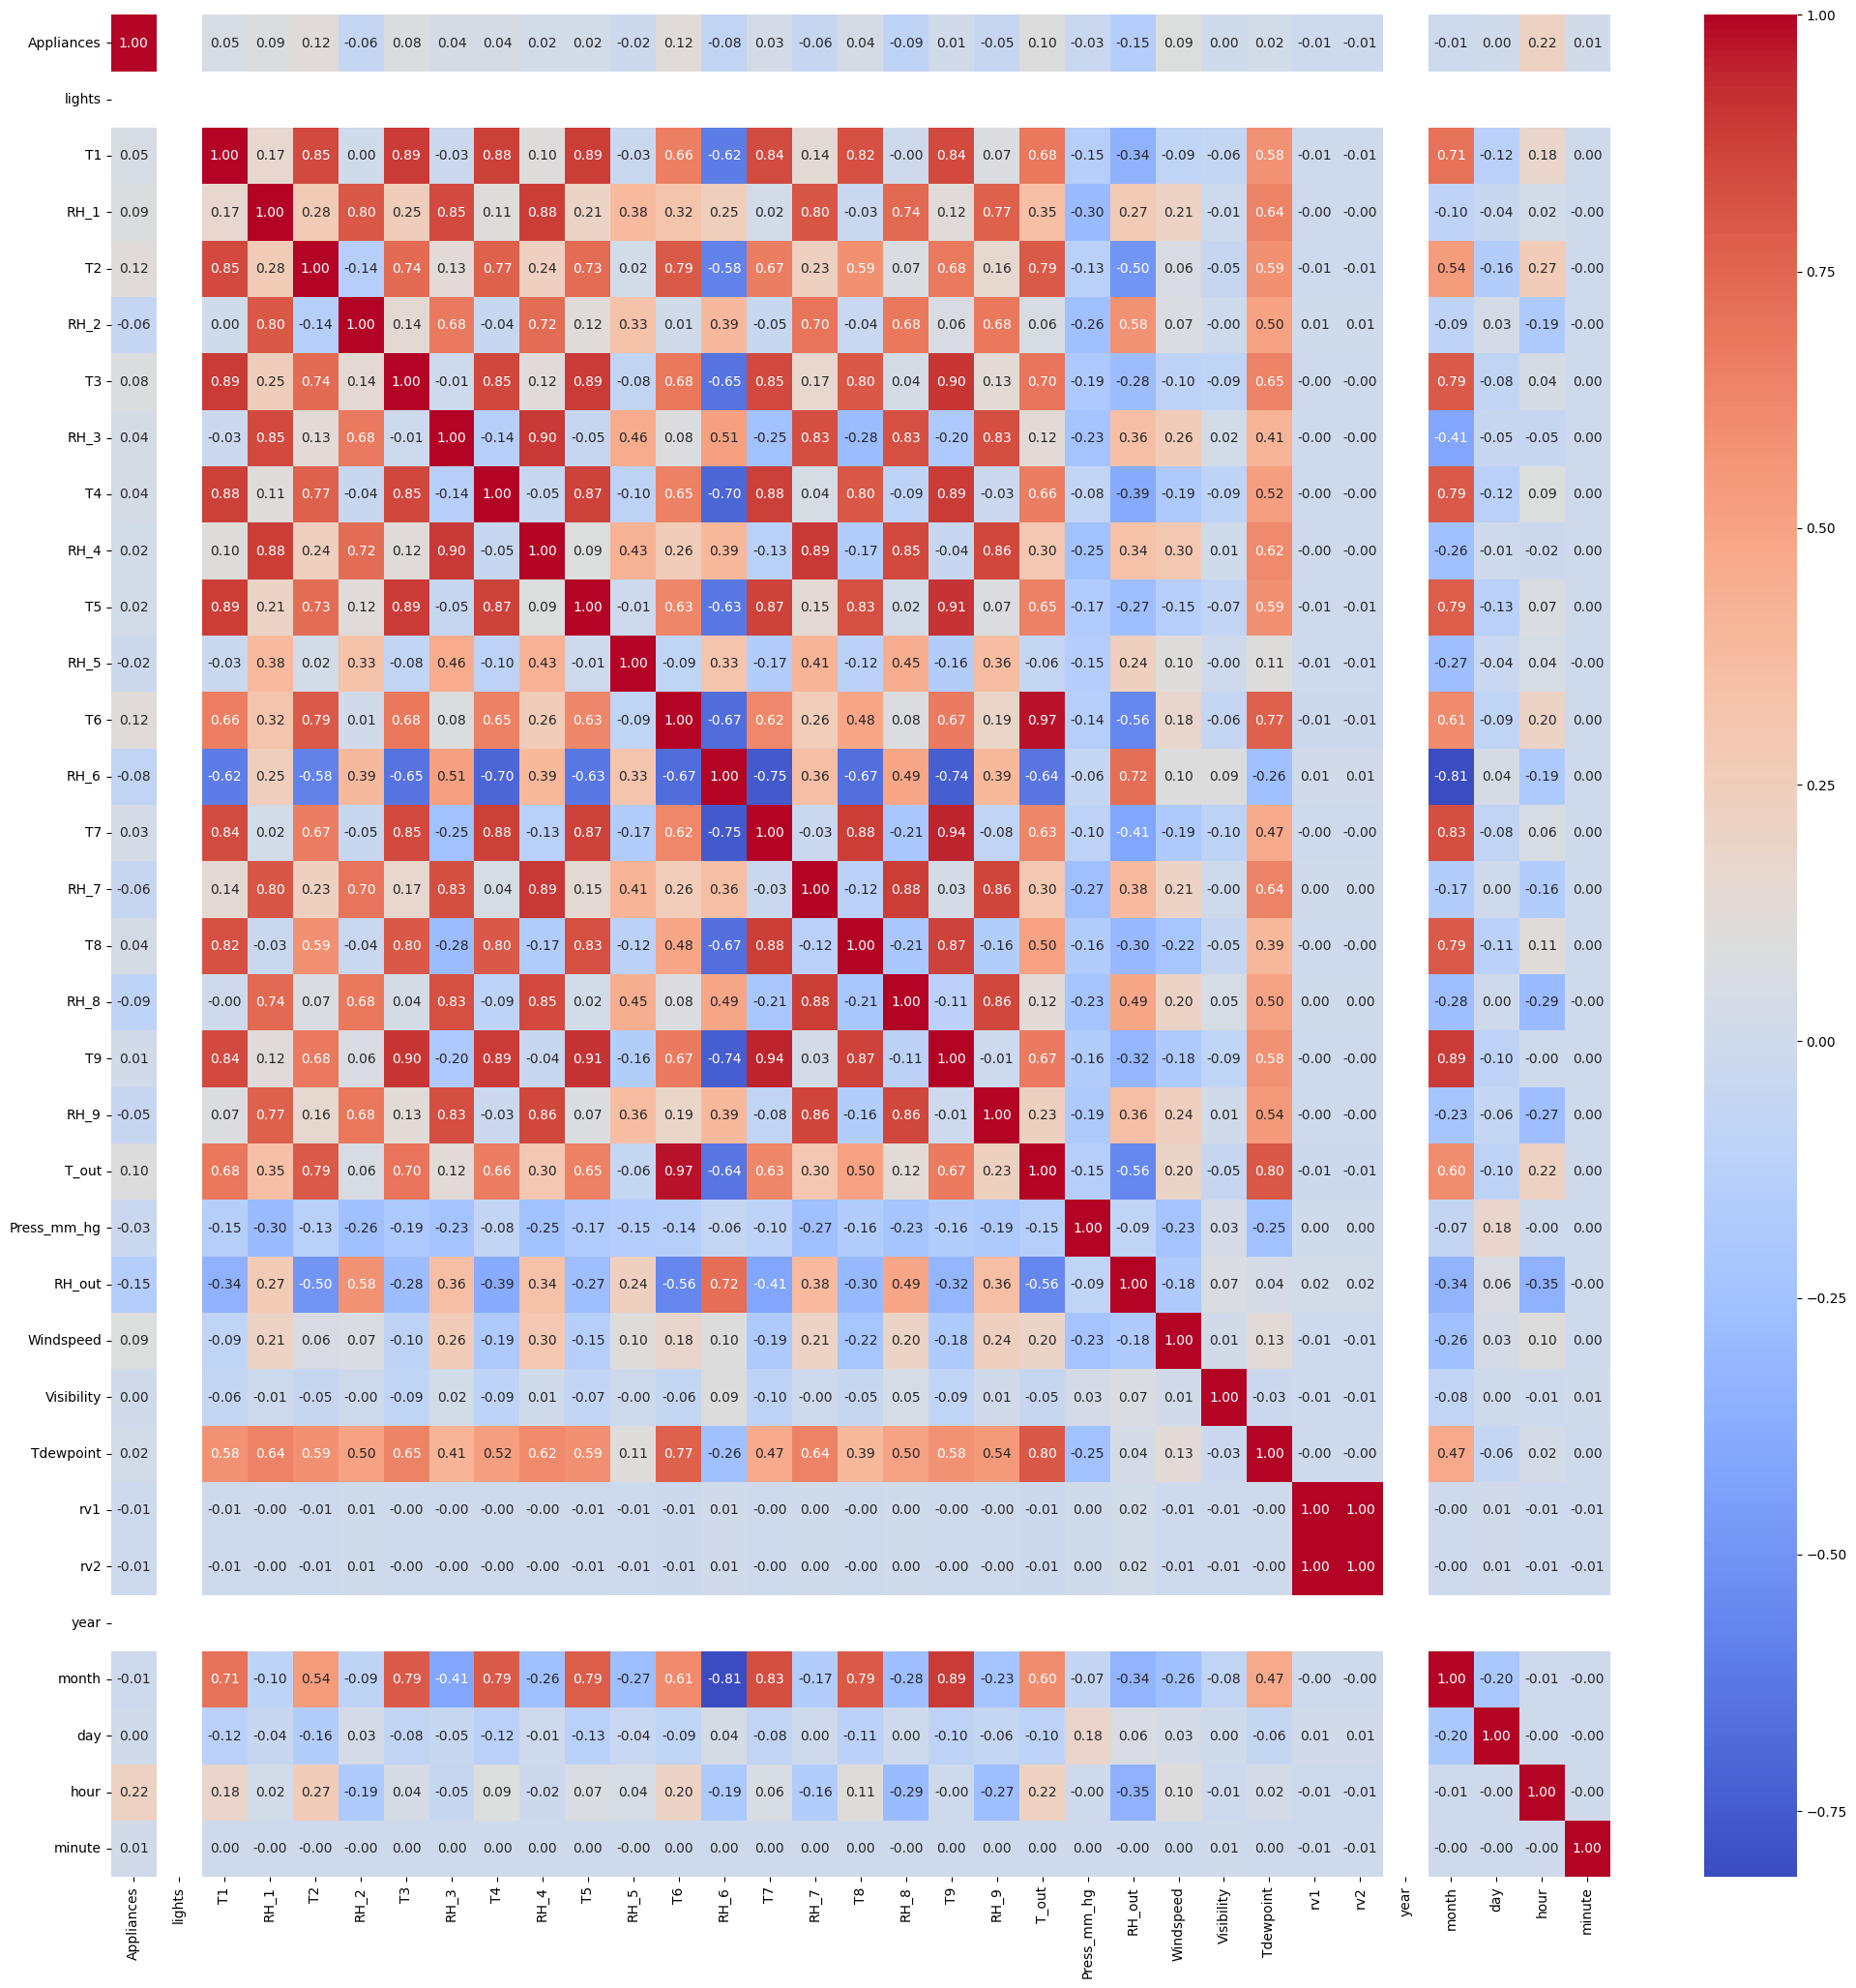

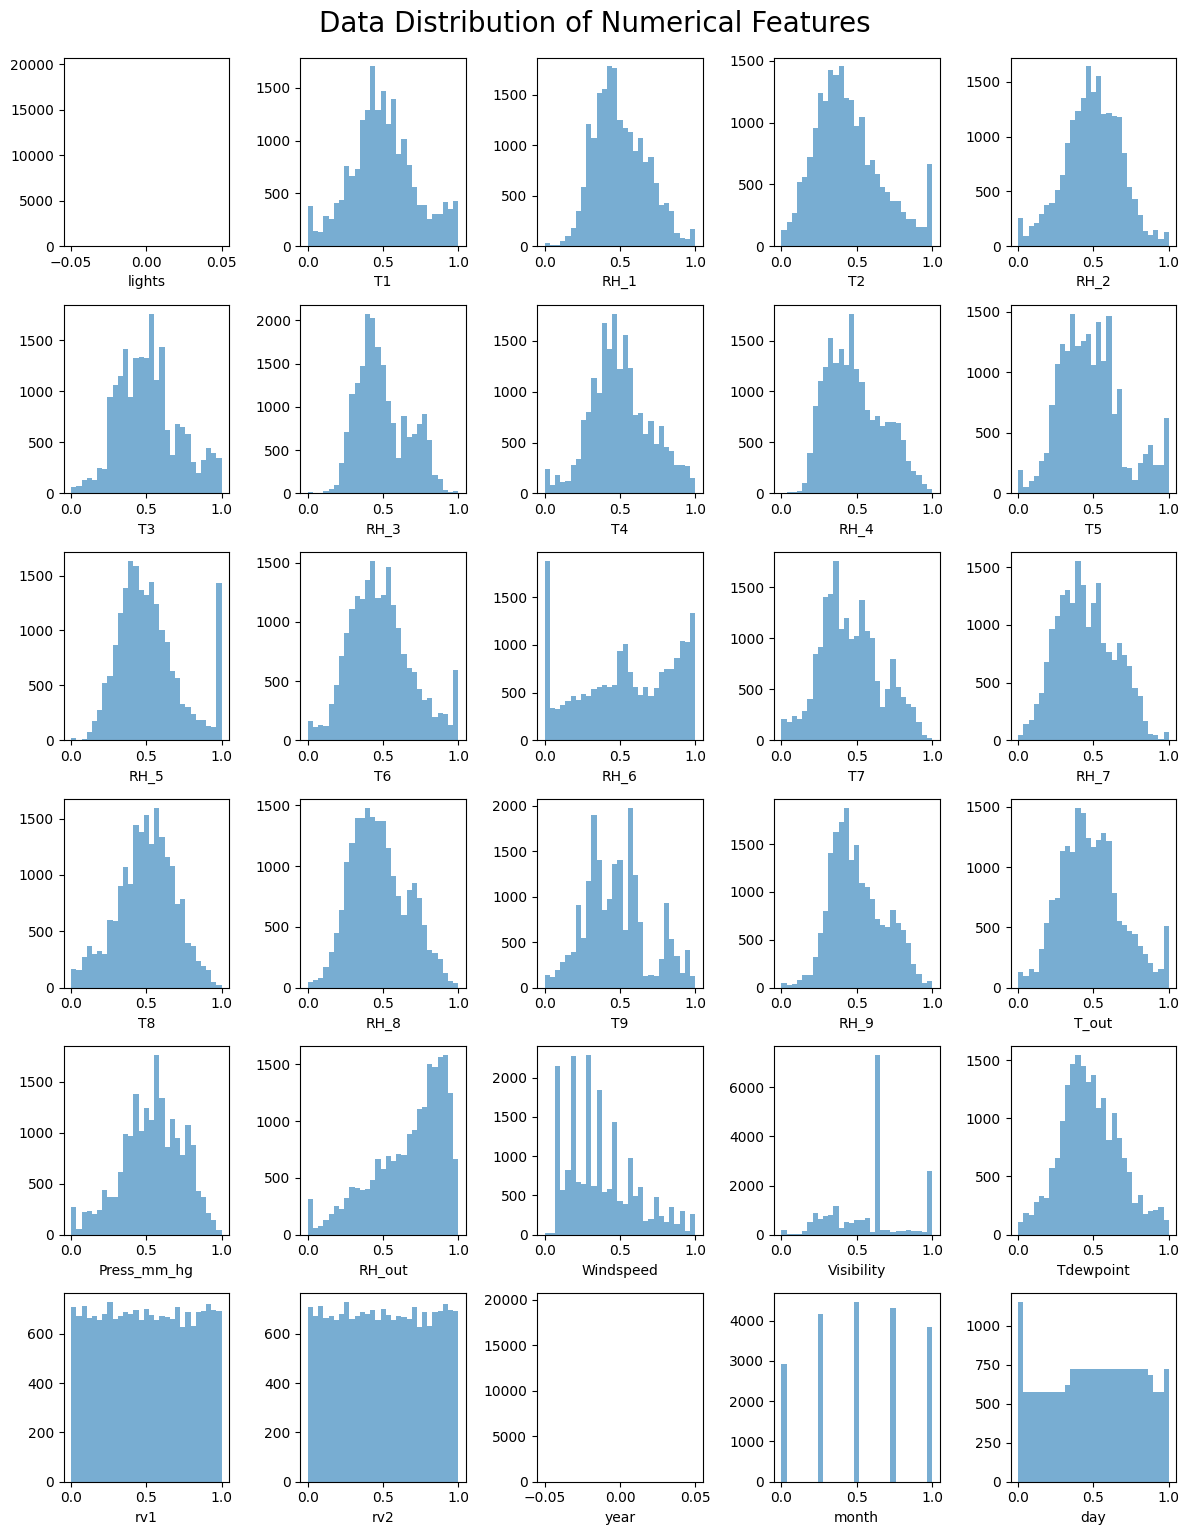



Selected features using Chi2 method are:
['T1', 'T2', 'RH_2', 'T3', 'T4', 'T5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out', 'Windspeed', 'Tdewpoint', 'month', 'hour']


The dimension of X_train is (13814, 32)
The dimension of X_test is (5921, 32)

Baseline Analysis:
                            OLS Regression Results                            
Dep. Variable:             Appliances   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     80.04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:33:13   Log-Likelihood:                -82590.
No. Observations:               13814   AIC:                         1.652e+05
Df Residuals:                   13784   BIC:                         1.655e+05
Df Model:                          29                               

In [ ]:
main()

In the above analysis, we have evaluated the performance of an OLS regression model with and without feature selection using Chi2.

In order to include the date into the analysis, we split it into year, month, day, hour and minute.

The R2 score of 0.14 in the training data indicates that the model explains approximately 14% of the variance in the training data.
On the other hand, the test set R2 score of 0.163 implies that the model's performance is slightly better when tested on test data. However, this performance is not substantial, indicating that the model may not generalize very well to new data.

When the same is analyzed on the data with feature selection we achieve lower performance results of 11.5% and 12.7% respectively. This may suggest that the model's baseline performance is a lot better than the one on feature selected data.

Additionally, the model's performance on both the test set and the training set in both the cases is relatively very low, suggesting that the model may not be able to capture all the relationships in the data.

### **Regression - Garment Worker Productivity**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):

  # Convert the datetime column to datetime format
  df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')


    # Extract year, month

  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year

  df.drop('date', axis=1, inplace=True)


  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

    # filling missing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)


  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous])  #Scaling and normalizing numerical data
  # Performing one-hot encoding on categorical columns
  df = one_hot_encode(df,categorical)

  return df

In [ ]:
def main():
  path='/content/garments_worker_productivity.csv'
  target = 'actual_productivity'
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  categorical = ['quarter', 'department','day']
  continuous = ['team', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)
  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ['quarter', 'department','day']



  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'rfe',10)

   # separating target from the data
  y = processed_df[target]
  selectedX = selected_df
  processed_df.drop(target, axis=1, inplace=True)
  baselineX = processed_df

  # splitting data into training and test sets
  X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
  X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_trainb.shape))
  print("The dimension of X_test is {}\n".format(X_testb.shape))

  print('Baseline Analysis:')
  modelb = ols_model_building(X_trainb, y_trainb)
  print(modelb.summary())
  print('\n')


  y_predb = modelb.predict(sm.add_constant(X_testb))

  r2_trainb = modelb.rsquared
  print('R2 Score for Training Set: ', r2_trainb)
  reg_evaluation(y_testb, y_predb, modelb)

  print('\n\n\nAnalysis with Feature Selection:')
  models = ols_model_building(X_trains, y_trains)
  print(models.summary())
  print('\n')

  y_preds = models.predict(sm.add_constant(X_tests))

  r2_trains = models.rsquared
  print('R2 Score for Training Set: ', r2_trains)
  reg_evaluation(y_tests, y_preds, models)


In [ ]:

main()

Features:  ['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
Processed Features:  ['team', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'month', 'year', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing', 'department_finishing ', 'department_sweing', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']
Selected features using Recursive Feature Elimination wrapper method are:
['quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Wednesday']


The dimension of X_train is (837, 25)
The dimension of X_test is (360, 25)

Baseline Analysis:
                             OL

The baseline model outperforms the model with feature selection in terms of R-squared, MAE, MSE, and RMSE, indicating that the selected features in the baseline model are more effective in explaining the variability in actual productivity.
The results also highlight potential issues with the model with feature selection, such as poor explanatory power and higher prediction errors.
It's important to review the feature selection process and potentially reconsider the choice of features or the method used for feature selection to improve model performance. Additionally, addressing issues such as multicollinearity may lead to more reliable results.

### **Regression - Life Expectancy**

In [ ]:
def data_preprocessing(df, categorical, continuous, target):



  headers = df.columns.tolist()
  headers.remove(target)

  # drop any column with missing values greater than 40% of total values
  cols=df.columns[df.isna().sum()*100/len(df)>40]
  df.drop(columns=cols,axis=1,inplace=True)

  # drop any row in target with missing values
  df.drop(df[df[target].isna()].index,inplace=True)

  # filling missiing values with mean of the data in all of continuous data
  for i in continuous:
    df[i].fillna(df[i].mean(), inplace=True)

    # filling missing values with mode of the data in categorical data
  for i in categorical:
    max=df[i].value_counts().iloc[0]
    df[i].fillna(max,inplace=True)

  # fixing outliers to replace them with minimum or maximum allowed values
  for col in continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[col]=np.where(df[col] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[col] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[col]))
  df.fillna(0, inplace=True)


  # scale the data such that all columns are in the range 0 to 1
  scaler=MinMaxScaler()
  df[continuous]=scaler.fit_transform(df[continuous])  #Scaling and normalizing numerical data
  # Performing one-hot encoding on categorical columns
  df = one_hot_encode(df,categorical)

  return df

In [ ]:
def main():
  path='/content/Regression.Life.Expectancy.csv'
  target ='Life expectancy '
  df = inputdata(path)
  headers = df.columns.tolist()
  headers.remove(target)
  print("Features: ", headers)
  # Define categorical and continuous columns
  categorical = ['Country', 'Status']
  continuous = ['Year','Adult Mortality','infant deaths','Alcohol','percentage expenditure','Hepatitis B','Measles ',' BMI ','under-five deaths ','Polio','Total expenditure','Diphtheria ',' HIV/AIDS','GDP','Population',' thinness  1-19 years',' thinness 5-9 years','Income composition of resources','Schooling']

  # preprocessing
  processed_df = data_preprocessing(df, categorical, continuous, target)
  # refreshing feature names after preprocessing
  headers = processed_df.columns.tolist()
  headers.remove(target)
  print("Processed Features: ", headers)
  categorical = ['Country', 'Status']



  # graphs to visualize all features
  #exploratory_analysis(processed_df, continuous, categorical, target)

  # Feature Selection using RFE method
  selected_df = feature_selection(processed_df, headers, target, 'mutualinfo', 8)

   # separating target from the data
  y = processed_df[target]
  selectedX = selected_df
  processed_df.drop(target, axis=1, inplace=True)
  baselineX = processed_df

  # splitting data into training and test sets
  X_trainb, X_testb, y_trainb, y_testb = train_test_split(baselineX, y, test_size=0.3, random_state=7)
  X_trains, X_tests, y_trains, y_tests = train_test_split(selectedX, y, test_size=0.3, random_state=7)

  print("The dimension of X_train is {}".format(X_trainb.shape))
  print("The dimension of X_test is {}\n".format(X_testb.shape))

  print('Baseline Analysis:')
  modelb = ols_model_building(X_trainb, y_trainb)
  print(modelb.summary())
  print('\n')

  y_predb = modelb.predict(sm.add_constant(X_testb))

  r2_trainb = modelb.rsquared
  print('R2 Score for Training Set: ', r2_trainb)
  reg_evaluation(y_testb, y_predb, modelb)

  print('\n\n\nAnalysis with Feature Selection:')
  models = ols_model_building(X_trains, y_trains)
  print(models.summary())
  print('\n')

  y_preds = models.predict(sm.add_constant(X_tests))

  r2_trains = models.rsquared
  print('R2 Score for Training Set: ', r2_trains)
  reg_evaluation(y_tests, y_preds, models)


In [ ]:
main()

Features:  ['Country', 'Year', 'Status', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
Processed Features:  ['Year', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Country_Afghanistan', 'Country_Albania', 'Country_Algeria', 'Country_Angola', 'Country_Antigua and Barbuda', 'Country_Argentina', 'Country_Armenia', 'Country_Australia', 'Country_Austria', 'Country_Azerbaijan', 'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Barbados', 'Country_Belarus', 'Count

The provided results indicate a strong performance of the model. The R-squared (R2) score of 0.829 for the training set suggests that approximately 82.9% of the variance in the target variable is explained by the features, indicating a good fit of the model to the training data. Additionally, the low values of the mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) at 2.939, 15.017, and 3.875, respectively, indicate that the model's predictions are close to the actual values on average, with relatively small errors.

Furthermore, the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values of 11425.70 and 11476.33, respectively, suggest that the model provides a good balance between goodness-of-fit and model complexity. Additionally, the very low p-value of 3.86e-70 indicates strong evidence against the null hypothesis, implying that the model is statistically significant and provides valuable insights into the relationship between the predictors and the target variable. Overall, these results suggest that the model performs well and offers reliable predictions for the given data.






